**Подключение библиотек и определение нужных функций**

In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph

''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(lambda x: ox.geocode_to_gdf(x, by_osmid=True)[['lat', 'lon']]).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df

''' Построение bbox '''
def create_graph_several_city(full_graph, my_network_type = None, my_filter = None):
    gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
    north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
    full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
    return full_graph_from_bbox

''' Построение датафрейма долгот и широт для морей и аэро '''
def create_df_to_graphs(kind_of, full_df_from, full_df_to):
    list_lat_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_from = full_df_from[full_df_from['kind_of'] == kind_of].lon.to_list()
    list_lat_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lat.to_list()
    list_lon_aero_to = full_df_to[full_df_to['kind_of'] == kind_of].lon.to_list()
    full_list_lat_aero = list_lat_aero_from + list_lat_aero_to
    full_list_lon_aero = list_lon_aero_from + list_lon_aero_to
    full_df_aero = pd.DataFrame({'x' : full_list_lon_aero, 'y' : full_list_lat_aero})
    return full_df_aero

''' Построение графа по точкам '''
def create_my_graphs(full_graph, full_df_aero):
    full_df_aero['new_nodes'] = ox.distance.nearest_nodes(full_graph, full_df_aero.x, full_df_aero.y)
    full_df_aero['osmid'] = full_df_aero['new_nodes']
    full_df_aero = full_df_aero.set_index('osmid')

    edge_dict = {'u': full_df_aero.new_nodes[:-1].values, 'v': full_df_aero.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

    graph_attrs = {"crs": "WGS84"}
    multi_digraph_aero = ox.convert.graph_from_gdfs(
        full_df_aero, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph_aero

''' Построение воздушного графа '''
def create_graph_aero(full_graph, full_df_from, full_df_to):
    f = create_df_to_graphs('aeroway', full_df_from, full_df_to)
    multi_digraph_aero = create_my_graphs(full_graph, f)
    return multi_digraph_aero

''' Построение морского графа '''
def create_graph_marine(full_g, full_df_from, full_df_to):

    df_marine = create_df_to_graphs('aeroway', full_df_from, full_df_to)
    full_df_marine_x = list(df_marine.x)
    full_df_marine_y = list(df_marine.y)

    for i in range(len(full_df_marine_x)):
        for j in range(i + 1, len(full_df_marine_y)):
            output = (marnet_geograph.get_shortest_path(
                origin_node={"latitude": full_df_marine_y[i],"longitude": full_df_marine_x[i]}, 
                destination_node={"latitude": full_df_marine_y[j],"longitude": full_df_marine_x[j]}
            ))
            list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
            list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
            full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})

            multi_digraph_marine = create_my_graphs(full_g, full_df_marine)
            
            full_g = nx.compose_all([full_g, multi_digraph_marine])

    return full_g

**Начала работы - определение нужных городов и построение графа автомобильных путей**

C:\Users\orenc\AppData\Local\Temp\ipykernel_13568\1040093830.py:52: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


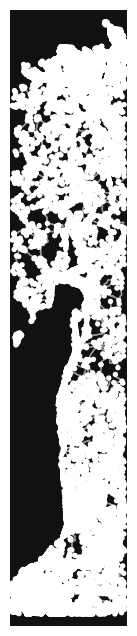

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
name_tallin = 'Tallin'
name_riga = 'Riga'

tallin = create_graph_city(name_tallin, my_network_type = 'drive')
riga = create_graph_city(name_riga, my_network_type = 'drive')
full_graph = nx.compose_all([tallin[1], riga[1]])

full_auto_graph = create_graph_several_city(full_graph, my_network_type = 'drive')

ox.plot_graph(full_auto_graph)

**Построение графа ЖД-путей**

C:\Users\orenc\AppData\Local\Temp\ipykernel_13568\1040093830.py:52: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


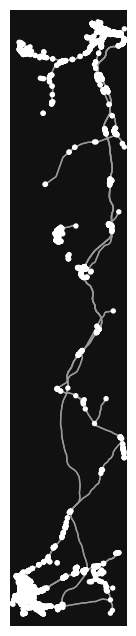

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
r_tallin = create_graph_city(name_tallin, my_filter = '["railway"~"."]')
r_riga = create_graph_city(name_riga, my_filter = '["railway"~"."]')
full_railway_graph = nx.compose_all([r_tallin[1], r_riga[1]])

only_railway_graph = create_graph_several_city(full_railway_graph, my_filter = '["railway"~"."]')

ox.plot_graph(only_railway_graph)

**Формирование датафрейма фич**

In [4]:
full_df_from = create_features_city(*tallin)
full_df_to = create_features_city(*riga)

**Определение графа морского пути**

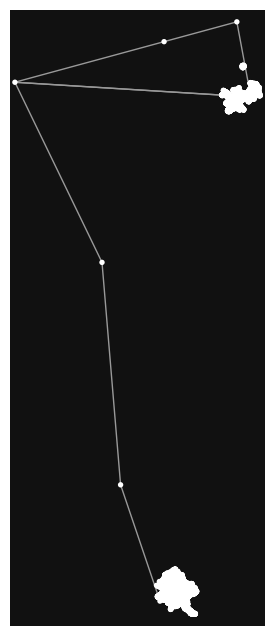

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
only_marine_graph = create_graph_marine(full_graph, full_df_from, full_df_to)
ox.plot_graph(only_marine_graph)

**Определение графа воздушного пути**

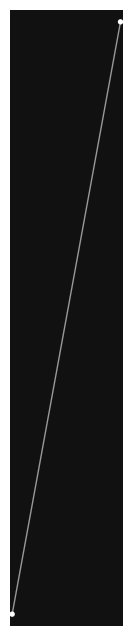

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
only_aero_graph = create_graph_aero(full_graph, full_df_from, full_df_to)
ox.plot_graph(only_aero_graph)

**Формирование полного графа**

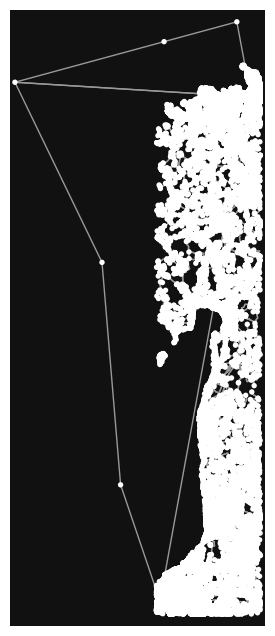

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
full = nx.compose_all([full_auto_graph, only_railway_graph, only_marine_graph, only_aero_graph])
ox.plot_graph(full)

**Соединение датафреймов фичей**

In [8]:
full_df_from['place'] = 'Tallin'
full_df_to['place'] = 'Riga'
full_feature_df = pd.concat([full_df_from, full_df_to], ignore_index=True)
# full

___
___

In [37]:
df_build = full_feature_df[full_feature_df['kind_of'] == 'building'].reset_index(drop=True)

In [38]:
def create_graph_route_building(input_graph, name_obj):

    df_1 = full_feature_df[full_feature_df['kind_of'] == name_obj].reset_index(drop=True)

    one_route = []
    list_f = []
    list_t = []
    for i in range(df_1.shape[0]):
        for j in range(i + 1, df_1.shape[0]):
            one_route.append(nx.shortest_path(input_graph, df_1['new_nodes'].iloc[i], df_1['new_nodes'].iloc[j]))
            list_f.append(df_1['name'].iloc[i])
            list_t.append(df_1['name'].iloc[j])

    route_df = pd.DataFrame({'from' : list_f, 'to' : list_t, 'route' : one_route})

    return route_df

In [39]:
def create_final_graph(arb_graph, my_route_df):
    list_graphs = []

    for i in range(my_route_df.route.shape[0]):
        
        r = my_route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])



    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(df_build['new_nodes'].values)

    n = nodes[nodes['new_nodes'].isin(list_nodes)]
    g = ox.convert.graph_from_gdfs(n, edges, graph_attrs=None)


    return g

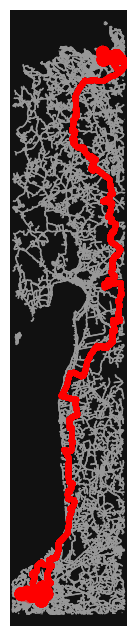

In [29]:
ox.distance.add_edge_lengths(full_auto_graph, edges=None)
route_df = create_graph_route_building(full_auto_graph, 'building')
fig, ax = ox.plot_graph_routes(full_auto_graph, list(route_df.route), route_colors='r', route_linewidth=6, node_size=0)

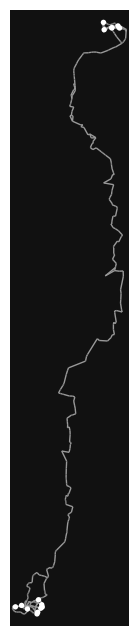

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [40]:
ox.plot_graph(create_final_graph(full_auto_graph, create_graph_route_building(full_auto_graph, 'building')))

___

**Построение графа между складами и портом в одном и другом городе**

In [13]:
def ccc(name_obj_from, name_obj_to):
    df_2_aero_tallin = full_feature_df[(full_feature_df['kind_of'] == name_obj_from) & (full_feature_df['place'] == name_tallin)].reset_index(drop=True)
    df_2_aero_riga = full_feature_df[(full_feature_df['kind_of'] == name_obj_from) & (full_feature_df['place'] == name_riga)].reset_index(drop=True)
    df_2_build_tallin = full_feature_df[(full_feature_df['kind_of'] == name_obj_to) & (full_feature_df['place'] == name_tallin)].reset_index(drop=True)
    df_2_build_riga = full_feature_df[(full_feature_df['kind_of'] == name_obj_to) & (full_feature_df['place'] == name_riga)].reset_index(drop=True)

    one_route_tallin = []
    one_route_riga = []

    for i in range(df_2_aero_tallin.shape[0]):
        for j in range(df_2_build_tallin.shape[0]):
            one_route_tallin.append(nx.shortest_path(full_auto_graph, df_2_aero_tallin['new_nodes'].iloc[i], df_2_build_tallin['new_nodes'].iloc[j]))
    route_marine_build_tallin = pd.DataFrame({'route' : one_route_tallin})

    for i in range(df_2_aero_riga.shape[0]):
        for j in range(df_2_build_riga.shape[0]):
            one_route_riga.append(nx.shortest_path(full_auto_graph, df_2_aero_riga['new_nodes'].iloc[i], df_2_build_riga['new_nodes'].iloc[j]))
    route_marine_build_riga = pd.DataFrame({'route' : one_route_riga})

    route_marine_build_tallin_riga = pd.concat([route_marine_build_tallin, route_marine_build_riga]).reset_index(drop=True)

    return route_marine_build_tallin_riga

In [15]:
def create_only_graph_marine(full_g, full_df_from, full_df_to):

    df_marine = create_df_to_graphs('industrial', full_df_from, full_df_to)
    full_df_marine_x = list(df_marine.x)
    full_df_marine_y = list(df_marine.y)

    list_multi_digraph_marine = []

    for i in range(len(full_df_marine_x)):
        for j in range(i + 1, len(full_df_marine_y)):
            output = (marnet_geograph.get_shortest_path(
                origin_node={"latitude": full_df_marine_y[i],"longitude": full_df_marine_x[i]}, 
                destination_node={"latitude": full_df_marine_y[j],"longitude": full_df_marine_x[j]}
            ))
            list_lat_marine = [output['coordinate_path'][i][0] for i in range(len(output['coordinate_path']))]
            list_lon_marine = [output['coordinate_path'][i][1] for i in range(len(output['coordinate_path']))]
            full_df_marine = pd.DataFrame({'x' : list_lon_marine, 'y' : list_lat_marine})

            multi_digraph_marine = create_my_graphs(full_g, full_df_marine)

            list_multi_digraph_marine.append(multi_digraph_marine)
            
    my_g = list_multi_digraph_marine[0]
    for i in range(1, len(list_multi_digraph_marine)):
        my_g = nx.compose_all([my_g, list_multi_digraph_marine[i]])

    return my_g

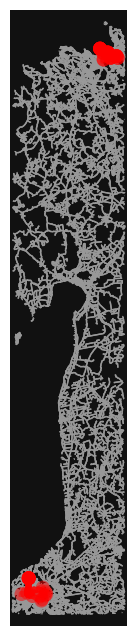

In [14]:
fig, ax = ox.plot_graph_routes(full_auto_graph, 
                               list(ccc('industrial', 'building').route), 
                               route_colors='r', route_linewidth=6, node_size=0)

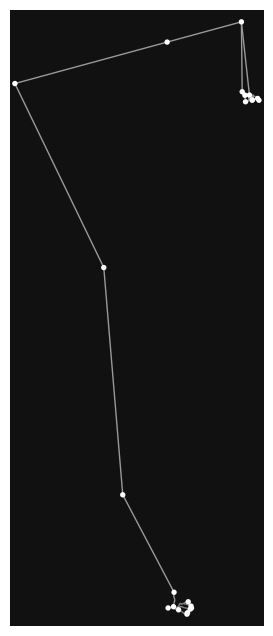

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [42]:
only_marine_graph_final = create_only_graph_marine(full_graph, full_df_from, full_df_to)
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('industrial', 'building'))
final_marine_graph = nx.compose_all([only_marine_graph_final, only_build_to_marine_graph_final])
ox.plot_graph(final_marine_graph)

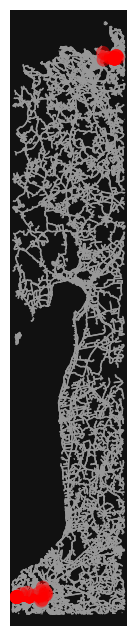

In [43]:
fig, ax = ox.plot_graph_routes(full_auto_graph, 
                               list(ccc('aeroway', 'building').route), 
                               route_colors='r', route_linewidth=6, node_size=0)

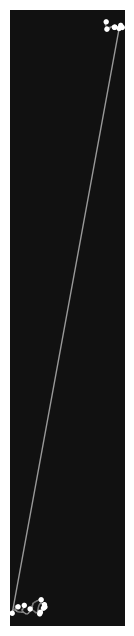

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
only_marine_graph_final = create_graph_aero(full_graph, full_df_from, full_df_to)
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('aeroway', 'building'))
final_marine_graph = nx.compose_all([only_marine_graph_final, only_build_to_marine_graph_final])
ox.plot_graph(final_marine_graph)

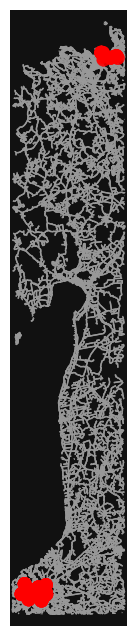

In [45]:
fig, ax = ox.plot_graph_routes(full_auto_graph, 
                               list(ccc('landuse', 'building').route), 
                               route_colors='r', route_linewidth=6, node_size=0)

C:\Users\orenc\AppData\Local\Temp\ipykernel_13568\1040093830.py:52: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


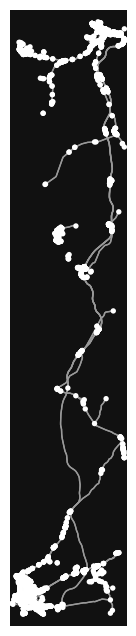

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [46]:
r_tallin = create_graph_city(name_tallin, my_filter = '["railway"~"."]')
r_riga = create_graph_city(name_riga, my_filter = '["railway"~"."]')
full_railway_graph = nx.compose_all([r_tallin[1], r_riga[1]])

only_railway_graph = create_graph_several_city(full_railway_graph, my_filter = '["railway"~"."]')
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('landuse', 'building'))
final_marine_graph = nx.compose_all([only_railway_graph, only_build_to_marine_graph_final])
ox.plot_graph(final_marine_graph)

**Соединить все графы**

In [47]:
final_drive = create_final_graph(full_auto_graph, create_graph_route_building(full_auto_graph, 'building'))

only_marine_graph_final = create_only_graph_marine(full_graph, full_df_from, full_df_to)
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('industrial', 'building'))
final_marine = nx.compose_all([only_marine_graph_final, only_build_to_marine_graph_final])

only_marine_graph_final = create_graph_aero(full_graph, full_df_from, full_df_to)
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('aeroway', 'building'))
final_aero = nx.compose_all([only_marine_graph_final, only_build_to_marine_graph_final])

only_railway_graph = create_graph_several_city(full_railway_graph, my_filter = '["railway"~"."]')
only_build_to_marine_graph_final = create_final_graph(full_auto_graph, ccc('landuse', 'building'))
final_railway = nx.compose_all([only_railway_graph, only_build_to_marine_graph_final])

final = nx.compose_all([final_drive, final_marine, final_aero, final_railway])

C:\Users\orenc\AppData\Local\Temp\ipykernel_13568\1040093830.py:52: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  full_graph_from_bbox = ox.graph_from_bbox(bbox = (north, south, east, west), simplify=True, retain_all=True, network_type = my_network_type, custom_filter = my_filter)
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


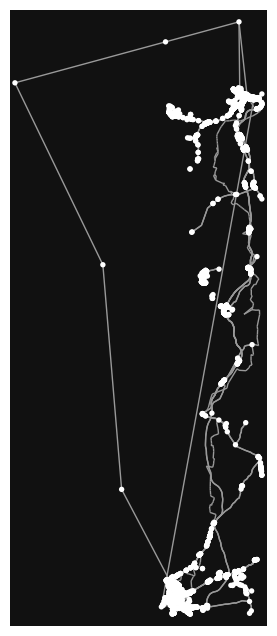

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [48]:
ox.plot_graph(final)

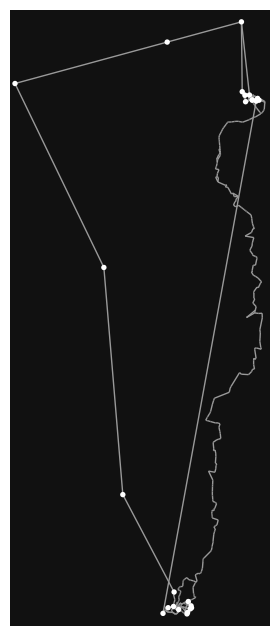

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [49]:
final = nx.compose_all([final_drive, final_marine, final_aero])
ox.plot_graph(final)

In [55]:
# nodes, edges = ox.graph_to_gdfs(final_marine)
# list_nodes = list(df_build['new_nodes'].values)

# n = nodes[nodes['new_nodes'].isin(list_nodes)]
# g = ox.convert.graph_from_gdfs(n, edges, graph_attrs=None)
ddd = full_feature_df
ddd
# final_marine.nodes

,name,lat,lon,geometry,nodes,kind_of,new_nodes,place
0,Paljassaare sadam,59.460184,24.707205,"POLYGON ((24.69967 59.45667, 24.69970 59.45668...","[[[962086465, 2354993602, 5133797405, 51338011...",industrial,278364190,Tallin
1,Vanasadam,59.444022,24.774418,"MULTIPOLYGON (((24.75972 59.44545, 24.76040 59...","[[[9055928766, 294510701, 11741309866, 5884596...",industrial,6726297219,Tallin
2,Tallinna lennujaam,59.414383,24.836851,"POLYGON ((24.87762 59.41361, 24.87396 59.41454...","[521306701, 521306702, 4264883505, 4264883510,...",aeroway,989935973,Tallin
3,Kopli kaubajaam,59.443773,24.719722,"POLYGON ((24.71114 59.44733, 24.71154 59.44724...","[1129498488, 1129498522, 1129498530, 105958075...",landuse,11780904,Tallin
4,Balti jaam,59.438961,24.733923,"POLYGON ((24.72755 59.43723, 24.73247 59.43881...","[7548499852, 8511990149, 8511990150, 419963212...",landuse,4622582280,Tallin
5,Ülemiste kaubajaam,59.422168,24.830341,"POLYGON ((24.79486 59.42350, 24.79518 59.42354...","[[[294495944, 715799245, 715478528, 715478629,...",landuse,693191997,Tallin
6,Horeca Service,59.419784,24.798040,"POLYGON ((24.79849 59.41946, 24.79878 59.41966...","[294494744, 2129683691, 294494749, 294494746, ...",building,291750883,Tallin
7,Valukoja parkimismaja,59.420184,24.801119,"POLYGON ((24.80042 59.42027, 24.80042 59.42006...","[294531623, 294531630, 294531631, 3437214004, ...",building,293896194,Tallin
8,Premia Tallinna Külmhoone,59.428557,24.846480,"POLYGON ((24.84560 59.42886, 24.84567 59.42875...","[294533602, 1635514916, 1635514918, 1635514917...",building,12293081,Tallin
9,Hoovimaja 3,59.411573,24.736587,"POLYGON ((24.73671 59.41144, 24.73687 59.41160...","[294487206, 294487207, 294487208, 294487201, 1...",building,385950102,Tallin


In [ ]:
def create_final_graph_1(arb_graph, my_route_df):
    list_graphs = []

    for i in range(my_route_df.route.shape[0]):
        
        r = my_route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])



    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(df_1['new_nodes'].values)

    n = nodes[nodes['new_nodes'].isin(list_nodes)]
    g = ox.convert.graph_from_gdfs(n, edges, graph_attrs=None)


    return g

In [56]:
full_feature_df[full_feature_df['kind_of'] == 'building']

,name,lat,lon,geometry,nodes,kind_of,new_nodes,place
6,Horeca Service,59.419784,24.798040,"POLYGON ((24.79849 59.41946, 24.79878 59.41966...","[294494744, 2129683691, 294494749, 294494746, ...",building,291750883,Tallin
7,Valukoja parkimismaja,59.420184,24.801119,"POLYGON ((24.80042 59.42027, 24.80042 59.42006...","[294531623, 294531630, 294531631, 3437214004, ...",building,293896194,Tallin
8,Premia Tallinna Külmhoone,59.428557,24.846480,"POLYGON ((24.84560 59.42886, 24.84567 59.42875...","[294533602, 1635514916, 1635514918, 1635514917...",building,12293081,Tallin
9,Hoovimaja 3,59.411573,24.736587,"POLYGON ((24.73671 59.41144, 24.73687 59.41160...","[294487206, 294487207, 294487208, 294487201, 1...",building,385950102,Tallin
10,DHL kaubaterminal,59.429146,24.852131,"POLYGON ((24.85288 59.42957, 24.85342 59.42880...","[717476925, 717476843, 8188503735, 8188503736,...",building,12293081,Tallin
11,Nordnet Logistics,59.427817,24.852341,"POLYGON ((24.85350 59.42836, 24.85392 59.42776...","[717476779, 8188503731, 8188503730, 717476757,...",building,12293081,Tallin
12,Laki Logistics,59.418039,24.860899,"POLYGON ((24.86047 59.41901, 24.86133 59.41901...","[721192849, 721192908, 721192924, 721192847, 7...",building,843781663,Tallin
13,Vabrik Wine & Grill,59.442722,24.733281,"POLYGON ((24.73363 59.44282, 24.73317 59.44247...","[294844250, 294844251, 11527449252, 294844252,...",building,146399104,Tallin
24,Startup House Riga,56.941423,24.117393,"POLYGON ((24.11734 56.94152, 24.11765 56.94146...","[1020531227, 1020531005, 1020531468, 102053127...",building,253891662,Riga
25,6 (DCP SIA),56.979090,24.209870,"POLYGON ((24.20951 56.97920, 24.20994 56.97887...","[1327216905, 1327216863, 1327216896, 132721691...",building,1472158137,Riga
